# Cancer Cell Lines Sig Loci Overlaps with TCGA BRCA

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
import matplotlib.pyplot as plt
from joblib import  Parallel, delayed
from multiprocessing import cpu_count
import seaborn as sns
import random
import json as js
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Merge All Cancer Cell Lines Enriched Loci

In [2]:
sig_loci = set()
fisher_loci = pd.read_csv("results/fisher/cell_lines_sig_loci_fisher.bed", sep="\t", header=None)
sig_loci.update(fisher_loci[3])
len(sig_loci)

771

In [3]:
deseq_loci = pd.read_csv("results/DESeq/cell_lines_sig_loci_deseq.bed", sep="\t", header=None)
sig_loci.update(deseq_loci[3])
len(sig_loci)

860

In [4]:
for s in os.scandir("results/DESeq_subtype/"):
    if s.name.endswith(".bed"):
        bed = pd.read_csv(s, sep="\t", header=None)
        print(s.name, bed.shape)
        sig_loci.update(bed[3])
        print(len(sig_loci))

Luminal_sig_loci_deseq.bed (279, 6)
1019
TNBC_sig_loci_deseq.bed (577, 6)
1248
Met_sig_loci_deseq.bed (239, 6)
1282
HER2_sig_loci_deseq.bed (460, 6)
1525


After merging all the various results, we have 1525 unique loci to then overlap with our TCGA data

In [5]:
with open(f"results/all_cell_lines_sig_loci.bed", "wt") as out:   
    for locus in sig_loci:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")  

## All Significant Cell Lines Loci

In [6]:
with open('data/counts/cell_lines_cpm_map.json', 'r') as f:
    cell_lines_cpm_map = js.load(f)
    f.close()
with open('data/counts/cell_lines_loci_counts.json', 'r') as f:
    sample_loci = js.load(f)
    f.close()

In [7]:
#Create df for heatmap visualization
loci_exp = {}
for locus in sig_loci:
    loci_exp[locus] = {}
    for cell_line, loci_dict in sample_loci.items():
        if locus in loci_dict:
            loci_exp[locus][cell_line] = loci_dict[locus] * cell_lines_cpm_map[cell_line] #Transform raw count to cpm. Note we use the cpm_map from non ex-filtered dataset to capture whole count.
        else:
            loci_exp[locus][cell_line] = 0

In [8]:
loci_exp_df = pd.DataFrame.from_dict(loci_exp, orient="index")

In [9]:
subtype_map = {"MDA453":"HER2+", "SKBR-3":"HER2+", 
              "HUMEC":"Normal", "ZR75-1":"Luminal", "HCC38": "TNBC",
              "CN34":"TNBC", "MCF7": "Luminal", "MDA231":"TNBC", 
              "LM2":"Met", "LM1a":"Met"}

In [10]:
colData = pd.DataFrame(loci_exp_df.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Cell Line"] = colData["Sample"].apply(lambda x: x.split("_")[0]) #From sample name, get cell line information
colData["Subtype"] = colData["Cell Line"].apply(lambda x: subtype_map[x]) #Base on cell line, map to subtype category
colData = colData.sort_values("Cell Line").sort_values("Subtype") #First sort by cell line then by subtype
colData = pd.concat([colData[colData["Subtype"] == "Normal"], colData[colData["Subtype"] != "Normal"]]).copy()
colData = colData.set_index("Subtype", drop=False)

colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [11]:
#Max norm
loci_df = np.zeros(loci_exp_df.shape)
for i in range(loci_exp_df.shape[0]):
    max_per_row = np.max(loci_exp_df.iloc[i])
    loci_df[i] = np.divide(loci_exp_df.iloc[i], max_per_row) #Max-norm

In [12]:
loci_df = pd.DataFrame(loci_df, index=loci_exp_df.index, columns=loci_exp_df.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1440x1440 with 0 Axes>

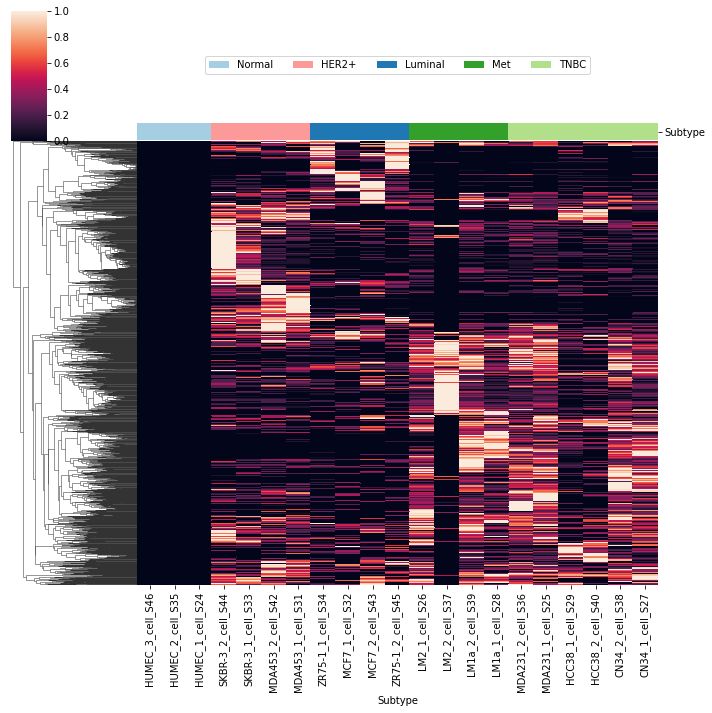

In [13]:
plt.figure(figsize=(20,20))
g=sns.clustermap(loci_df, col_cluster=False, col_colors=col_colors,yticklabels=False, xticklabels=colData["Sample"], method="average", rasterized=True)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/cell_lines_all_sig_loci_heatmap.pdf")

## Process TCGA Data

### Intersect TCGA Bed Files with Significant Cell Lines Loci

Command: <br>
`ls /rumi/shams/jwang/BRCA_oncRNA/data/TCGA/*.filter.bed | parallel -j 20 bash scripts/intersect_TCGA_loci.sh {} &> log/TCGA_intersect.out`


## Create TCGA Counts Dictionary

In [14]:
def processLociInput(f):
    bed_file = pd.read_csv(f, header=None, sep="\t")
    sample = f.split("/")[-1].split(".")[0]
    
    preintersect = f"{sample}.filter.bed"
    preintersect_bed = pd.read_csv(f"data/TCGA/{preintersect}", header=None, sep="\t")
    cpm = 1000000 / preintersect_bed.shape[0]  

    loci_features = bed_file[9] #Locus annotation as a feature, based on previously created feature map in preprocess_data.ipynb
    loci_bp_overlaps = bed_file[12]
    read_ids = bed_file[3] #Query ID from original TCGA bamfile for each read.
    
    #Create read_id map
    read_id_locus_map = {}
    for i in range(len(read_ids)):
        _id = read_ids.iloc[i]
        num_bp_match = loci_bp_overlaps.iloc[i]
        locus = loci_features.iloc[i]
        
        if _id in read_id_locus_map: #Indicates multiple hits/overlaps
            if num_bp_match > read_id_locus_map[_id]["bp"]: #Update locus count if more number of bp matched.
                read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
        else:
            read_id_locus_map[_id] = {"locus":locus, "bp":num_bp_match}
            
    assert len(read_id_locus_map) == len(bed_file[3].unique()) #Ensures we do not overcount reads
    
    sample_loci = {}
    sample_loci[sample] = {}
    sample_loci["cpm"] = cpm
    for _id in read_id_locus_map:
        locus = read_id_locus_map[_id]["locus"]
        if locus in sample_loci[sample]:
            sample_loci[sample][locus] += 1
        else:
            sample_loci[sample][locus] = 1      
            
    return sample_loci      

In [15]:
brca_bed = [f.path for f in os.scandir("data/TCGA/") if f.name.endswith(".loci.bed")]
results = Parallel(n_jobs=20)(delayed(processLociInput)(i) for i in brca_bed)

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [16]:
len(results)

1782

https://github.com/scikit-learn/scikit-learn/issues/14626
<br> Seems like a common warning.

In [17]:
brca_sample_loci = {}
brca_cpm_map = {}
for r in results:
    for key, val in r.items(): #Only two keys: cpm and sample name
        if key != "cpm": 
            sample = key
            brca_sample_loci[key] = val
        else:
            cpm = val
            
    brca_cpm_map[sample] = cpm

In [18]:
with open('data/counts/brca_sig_cell_lines_loci.json', 'w') as f:
    js.dump(brca_sample_loci, f)
    f.close()

In [19]:
with open('data/counts/brca_cpm_map.json', 'w') as f:
    js.dump(brca_cpm_map, f)
    f.close()

## Run Normal Filter Threshold and Fisher Test
Here we run the normal filter thresholding along with Fisher Test on the overlapping loci.

## Group Normals

In [20]:
tcga_metadata = pd.read_csv("metadata/TCGA_metadata.csv")
tcga_metadata = tcga_metadata.set_index("TCGAbarcode", drop=False)

normal_metadata = tcga_metadata[tcga_metadata["Sample"].str.contains("normal")]
normal_counts = normal_metadata.groupby("TCGA_abb", as_index=False)["Sample"].count()
normal_counts = normal_counts[normal_counts["Sample"] >= 10].set_index("TCGA_abb", drop=False) #Only use normal tissue if at least 10 normal samples of that tissue

In [21]:
brca_samples = set(tcga_metadata[(~tcga_metadata["Sample"].str.contains("normal")) & (tcga_metadata["TCGA_abb"].str.contains("BRCA"))]["TCGAbarcode"])
normal_samples = set(tcga_metadata[tcga_metadata["Sample"].str.contains("normal")]["TCGAbarcode"])
len(brca_samples), len(normal_samples)

(1103, 679)

## Stratified Normal Filter

In [22]:
#Create counts of number of samples that have a particular locus
brca_loci = {}
norm_loci = {}
for sample, locus_dict in brca_sample_loci.items():
    if sample in brca_samples:      
        for locus in locus_dict:
            if locus in brca_loci:
                brca_loci[locus] += 1
            else:
                brca_loci[locus] = 1
    else:
        normal_type = tcga_metadata.loc[sample]["TCGA_abb"]
        assert "normal" in tcga_metadata.loc[sample]["Sample"]
        for locus in locus_dict:
            if locus in norm_loci:
                if normal_type in norm_loci[locus]:
                    norm_loci[locus][normal_type] += 1
                else:
                    norm_loci[locus][normal_type] = 1
            else:
                norm_loci[locus] = {normal_type:1}
len(brca_loci), len(norm_loci)

(1170, 1140)

In [23]:
#This only includes normal tissue that have at least 10 samples.
normal_counts_dict = dict(zip(normal_counts["TCGA_abb"], normal_counts["Sample"]))

In [24]:
brca_thresh = 0.05 #For now we will keep this constant
fdr_overlaps = []
sig_overlaps = []

for i in range(1, 51):
    fil_brca_loci = {}
    fil_norm_loci = {}
    norm_thresh = i/100
    total_skipped = 0
    for locus in brca_loci: #We are not interested in RNAs not found in brca_rnas, hence we only consider brca_rnas
        if brca_loci[locus] < 1103 * brca_thresh: #Skip if not in at least 10% of BRCA cancer samples 
            continue  
            
        total_normal_count = 0
        #Threshold by normal tissue type.
        if locus in norm_loci:
            to_skip = False
            for normal_type, count in norm_loci[locus].items():
                #Special max filter for BRCA normal tissues that is fixed.
                if normal_type == "BRCA" and count > 0.15 * normal_counts_dict["BRCA"]:
                    to_skip = True
                    break
                elif normal_type in normal_counts_dict and count > norm_thresh * normal_counts_dict[normal_type]: #Stratified normal tissue filter
                    to_skip = True
                    break
                else:
                    total_normal_count += count
                    
            if to_skip:
                total_skipped += 1
                continue #Skips this particular locus if it fails the criteria in at least one of the normal tissue.
                            
        fil_norm_loci[locus] = total_normal_count #Otherwise pool all the counts in all the normal tissues if passed the stratified normal tissue filter      
        fil_brca_loci[locus] = brca_loci[locus]
     
    #Fisher
    tcga_locus_pval = {}
    for locus in fil_brca_loci:
        test_count = fil_brca_loci[locus]
        ctrl_count = fil_norm_loci[locus]
        oddsratio, pvalue = stats.fisher_exact([[test_count, ctrl_count],[1103-test_count, 679-ctrl_count]], "greater")
        tcga_locus_pval[locus] = pvalue
        
    tcga_locus_pval_df = pd.DataFrame.from_dict(tcga_locus_pval, orient="index", columns=["pval"])
    
    rej, fdr = fdrcorrection(tcga_locus_pval_df["pval"], alpha=0.1)
    tcga_locus_pval_df["fdr"] = fdr  
    fdr_tcga_locus_df = tcga_locus_pval_df[tcga_locus_pval_df["fdr"] <= 0.1]
    sig_tcga_locus_df = tcga_locus_pval_df[tcga_locus_pval_df["pval"] <= 0.1]
    
    fdr_overlaps.append(fdr_tcga_locus_df.shape[0])
    sig_overlaps.append(sig_tcga_locus_df.shape[0])
    
    with open(f"results/thresholds/{i}%_strat_sig_tcga.bed", "w") as sig_out:
        for locus in sig_tcga_locus_df.index:
            ref = locus.split(":")[0]
            strand = locus.split(":")[-1]
            start = locus.split(":")[1].split("-")[0]
            end = locus.split(":")[1].split("-")[1]
            bed = f"{ref}\t{start}\t{end}\t{locus}\t.\t{strand}"
            sig_out.write(bed + "\n")
    
    with open(f"results/thresholds/{i}%_strat_fdr_tcga.bed", "w") as fdr_out:
        for locus in fdr_tcga_locus_df.index:
            ref = locus.split(":")[0]
            strand = locus.split(":")[-1]
            start = locus.split(":")[1].split("-")[0]
            end = locus.split(":")[1].split("-")[1]
            bed = f"{ref}\t{start}\t{end}\t{locus}\t.\t{strand}"
            fdr_out.write(bed + "\n")

In [25]:
overlap_results = {"sig":sig_overlaps, "fdr":fdr_overlaps, "threshold": [p/100 for p in range(1, 51)]}
overlap_results = pd.DataFrame(overlap_results)

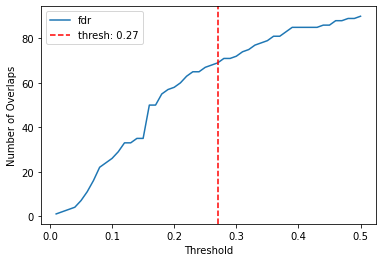

In [26]:
plt.plot('threshold', 'fdr', data=overlap_results)
plt.xlabel("Threshold")
plt.ylabel("Number of Overlaps")
ax = plt.gca()
ax.axvline(0.27, color = "r", ls="--", label="thresh: 0.27")
plt.legend()
plt.savefig("figures/num_overlaps_vs_strat_norm_filter_thresh.pdf")

## Overall Normal Tissue Filter

In [27]:
#Create counts of number of samples that have a particular locus
brca_loci = {}
norm_loci = {}
for sample, locus_dict in brca_sample_loci.items():
    if sample in brca_samples:      
        for locus in locus_dict:
            if locus in brca_loci:
                brca_loci[locus] += 1
            else:
                brca_loci[locus] = 1
    else:
        for locus in locus_dict:
            if locus in norm_loci:
                norm_loci[locus] += 1
            else:
                norm_loci[locus] = 1

In [28]:
brca_thresh = 0.05 #For now we will keep this constant
fdr_overlaps = []
sig_overlaps = []
for i in range(1, 51):
    fil_brca_loci = {}
    fil_norm_loci = {}
    norm_thresh = i/100
    for locus in brca_loci: #We are not interested in RNAs not found in brca_rnas, hence we only consider brca_rnas
        if locus in brca_loci and brca_loci[locus] < 1103 * brca_thresh: 
            continue         
        if locus in norm_loci and norm_loci[locus] > 679 * norm_thresh:
            continue

        if locus in brca_loci:
            fil_brca_loci[locus] = brca_loci[locus]
        else:
            fil_brca_loci[locus] = 0 #Not present. This line is not very necessary as all the loci we are looking at are coming from brca_loci, but here for ease of reading

        if locus in norm_loci:
            fil_norm_loci[locus] = norm_loci[locus]
        else:
            fil_norm_loci[locus] = 0 #Not present
       
    #Fisher
    tcga_locus_pval = {}
    for locus in fil_brca_loci:
        test_count = fil_brca_loci[locus]
        ctrl_count = fil_norm_loci[locus]
        oddsratio, pvalue = stats.fisher_exact([[test_count, ctrl_count],[1103-test_count, 679-ctrl_count]], "greater")
        tcga_locus_pval[locus] = pvalue
        
    tcga_locus_pval_df = pd.DataFrame.from_dict(tcga_locus_pval, orient="index", columns=["pval"])
    
    rej, fdr = fdrcorrection(tcga_locus_pval_df["pval"], alpha=0.1)
    tcga_locus_pval_df["fdr"] = fdr  
    fdr_tcga_locus_df = tcga_locus_pval_df[tcga_locus_pval_df["fdr"] <= 0.1]
    sig_tcga_locus_df = tcga_locus_pval_df[tcga_locus_pval_df["pval"] <= 0.1]

    fdr_overlaps.append(fdr_tcga_locus_df.shape[0])
    sig_overlaps.append(sig_tcga_locus_df.shape[0])
    
    with open(f"results/thresholds/{i}%_sig_tcga.bed", "w") as sig_out:
        for locus in sig_tcga_locus_df.index:
            ref = locus.split(":")[0]
            strand = locus.split(":")[-1]
            start = locus.split(":")[1].split("-")[0]
            end = locus.split(":")[1].split("-")[1]
            bed = f"{ref}\t{start}\t{end}\t{locus}\t.\t{strand}"
            sig_out.write(bed + "\n")
    
    with open(f"results/thresholds/{i}%_fdr_tcga.bed", "w") as fdr_out:
        for locus in fdr_tcga_locus_df.index:
            ref = locus.split(":")[0]
            strand = locus.split(":")[-1]
            start = locus.split(":")[1].split("-")[0]
            end = locus.split(":")[1].split("-")[1]
            bed = f"{ref}\t{start}\t{end}\t{locus}\t.\t{strand}"
            fdr_out.write(bed + "\n")

In [29]:
overlap_results = {"fdr":fdr_overlaps, "threshold": [p/100 for p in range(1, 51)]}
overlap_results = pd.DataFrame(overlap_results)

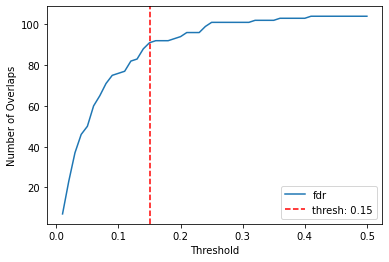

In [30]:
plt.plot('threshold', 'fdr', data=overlap_results)
plt.xlabel("Threshold")
plt.ylabel("Number of Overlaps")
ax = plt.gca()
ax.axvline(0.15, color = "r", ls="--", label="thresh: 0.15")
plt.legend()
plt.savefig("figures/num_overlaps_vs_overall_norm_filter_thresh.pdf")

In [31]:
overall_filter = pd.read_csv("results/thresholds/15%_fdr_tcga.bed", header=None, sep="\t").set_index(3, drop=False)
strat_filter = pd.read_csv("results/thresholds/27%_strat_fdr_tcga.bed", header=None, sep="\t")
overall_filter.shape[0], strat_filter.shape[0]

(91, 69)

In [32]:
sig_brca_sig_cl_df = overall_filter.loc[strat_filter[3]].reset_index(drop=True)
sig_brca_sig_cl_df.shape

(69, 6)

In [33]:
sig_brca_sig_cl_df.to_csv("results/thresholded_oncRNAs.bed", header=None, sep="\t", index=None)

After discussion with Hani, here we combine the results of a 27% stratified normal filter with a 15% overall normal filter. The idea behind these filters is that we don't want to identify RNAs that are found in 100% of a single normal tissue.

Here we make sure that none of are oncRNAs map to known smRNAs.

In [34]:
%%bash
bedtools intersect -wo -s -a results/thresholded_oncRNAs.bed -b /rumi/shams/jwang/genomes/oldhg38/dashr.v2.smRNA.hg38.bed

## Plot Significant Loci in TCGA BRCA

In [35]:
samples = []
samples.extend(normal_samples)
samples.extend(brca_samples)

In [36]:
sig_brca_sig_cl_loci = np.zeros((69, len(samples)))
sig_brca_sig_cl_binary_loci = np.zeros((69, len(samples)))

i = 0
brca_cl_loci_index = []
for locus in sig_brca_sig_cl_df[3]:
    brca_cl_loci_index.append(locus)
    for j in range(len(samples)):
        s = samples[j]
        loci_dict = brca_sample_loci[s]
        if locus in loci_dict:
            sig_brca_sig_cl_loci[i,j] = loci_dict[locus] * brca_cpm_map[s] #cpm norm
            sig_brca_sig_cl_binary_loci[i,j] = 1               
    i += 1

In [37]:
colData = pd.DataFrame(samples, columns=["Barcode"]) #Sample column contains all the samples
colData["Sample"] = colData["Barcode"].apply(lambda x: tcga_metadata[tcga_metadata["TCGAbarcode"] == x]["Sample"].item()) #Base on cell line, map to subtype category
colData["Type"] = colData["Sample"].apply(lambda x: "Normal" if "normal" in x else "Cancer")
colData = pd.concat([colData[colData["Type"] == "Normal"], colData[colData["Type"] != "Normal"]]).copy()
colData = colData.set_index("Type", drop=False)
colors = sns.color_palette("Paired", len(colData["Type"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Type"].unique()), colors))
col_colors = colData["Type"].map(lut)

In [38]:
sig_brca_sig_cl_binary_loci_df = pd.DataFrame(sig_brca_sig_cl_binary_loci , columns=samples, index=brca_cl_loci_index)
binary_df = sig_brca_sig_cl_binary_loci_df[list(colData["Barcode"])].copy() #Sort
binary_df.columns = colData["Type"] #Switch column name to just cell line type

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


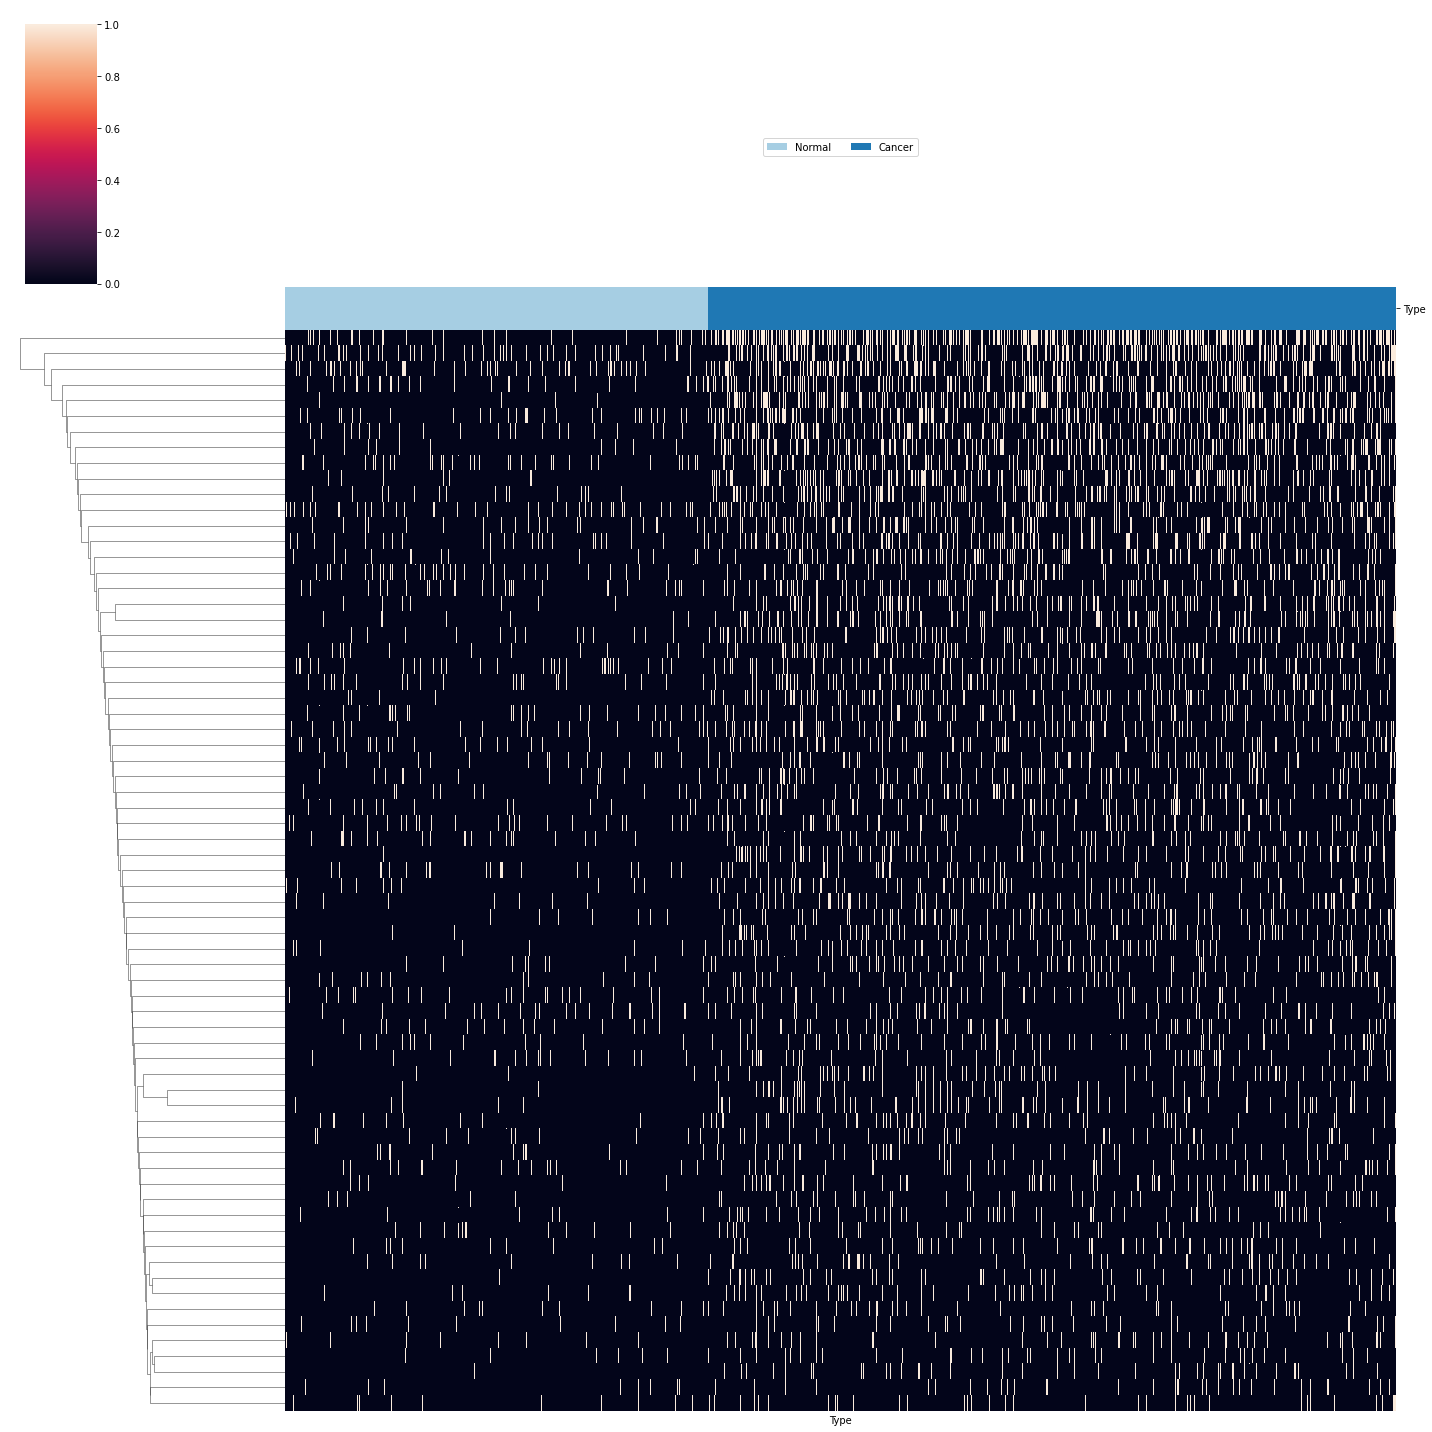

In [39]:
g=sns.clustermap(binary_df,figsize=(20,20), col_cluster=False, col_colors=col_colors, yticklabels=False, xticklabels=False, rasterized=True)
for label in colData["Type"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/sig_loci_overlaps_binary_heatmap.pdf")

In [40]:
#First we row normalize the expression for visualization
norm_sig_brca_sig_cl_loci = np.zeros((69, len(samples)))
for i in range(sig_brca_sig_cl_loci.shape[0]):
    max_per_row = np.percentile(sig_brca_sig_cl_loci[i], 99)
    norm_sig_brca_sig_cl_loci[i] = np.divide(sig_brca_sig_cl_loci[i], max_per_row) #Max-norm

In [41]:
norm_sig_brca_sig_cl_loci_df = pd.DataFrame(norm_sig_brca_sig_cl_loci, columns=samples, index=brca_cl_loci_index)
exp_df = norm_sig_brca_sig_cl_loci_df[list(colData["Barcode"])].copy() #Sort
exp_df.columns = colData["Type"] #Switch column name to just cell line type

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


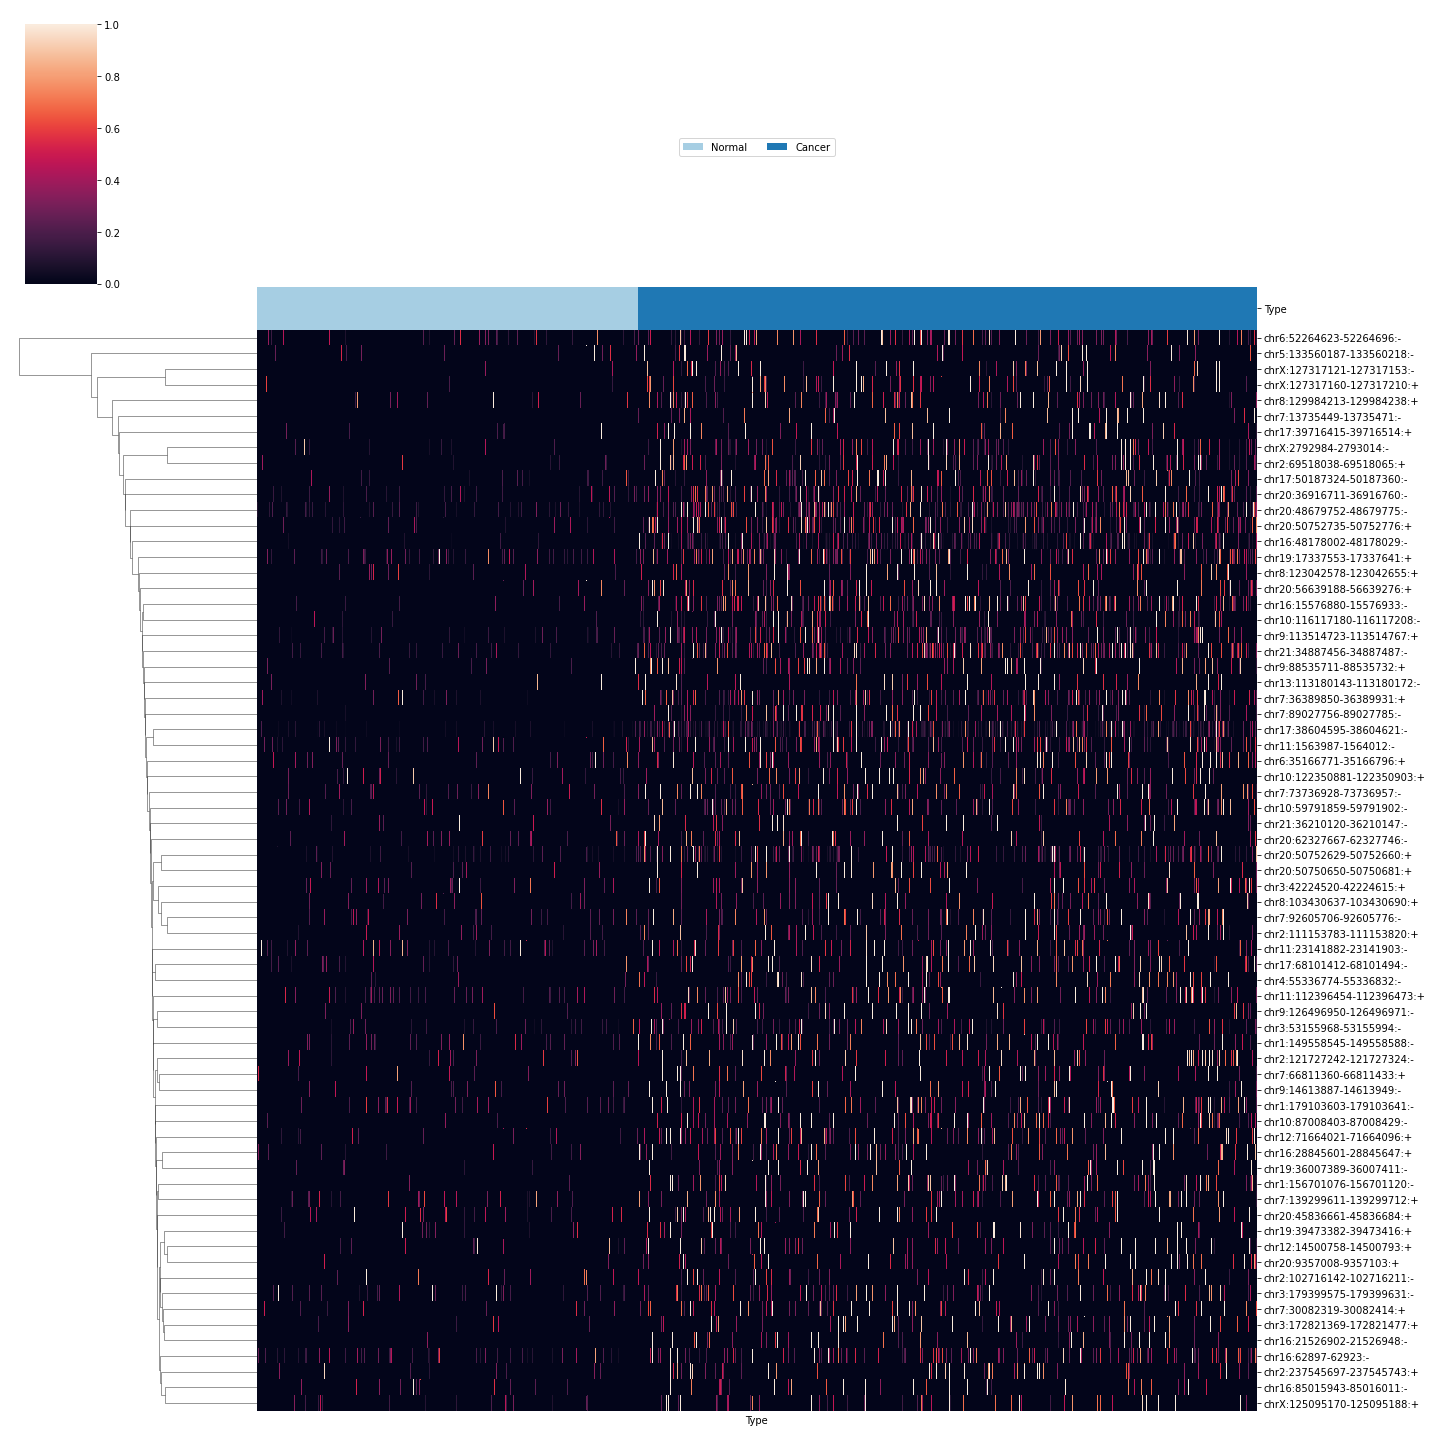

In [42]:
g=sns.clustermap(exp_df,figsize=(20,20), col_cluster=False, col_colors=col_colors, xticklabels=False, vmax=1, rasterized=True)
for label in colData["Type"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/sig_loci_overlaps_exp_heatmap.pdf")

# Done